In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from astropy.coordinates import get_sun, SkyCoord, EarthLocation, AltAz, get_moon
from astropy.time import Time
from lsst.sims.utils import Site, raDec2Hpid, m5_flat_sed
from astropy import units as u
from lsst.sims.skybrightness_pre import SkyModelPre
import healpy as hp
from lsst.sims.seeingModel import SeeingModel
from lsst.sims.downtimeModel import ScheduledDowntimeData

In [2]:
site = Site('LSST')
location = EarthLocation(lat=site.latitude, lon=site.longitude,height=site.height)

In [110]:
nyears = 2.2
mjd = np.arange(59853.5, 59853.5+365.25*nyears, 20./60/24.)
times = Time(mjd, format='mjd', location=location)

airmass_limit = 2.5 # demand airmass lower than this
twilight_limit = -18.  # Sun below this altitude in degrees
dist_to_moon_limit = 30.  # minimum distance to keep from moon degrees
zenith_limit = 10.  # Need to be this far away from zenith to start (20 min = 5 deg)
g_m5_limit = 23.5  # mags

season_gap = 20.  # days. Count any gap longer than this as it's own season
season_length_limit = 100 # Days. Demand at least this many days in a season

# How long to keep attempting a DDF
expire_dict = {1: 36./24., 2: 0.5}

In [4]:
sun_coords = get_sun(times)
moon_coords = get_moon(times)

In [5]:
sched_downtime_data = ScheduledDowntimeData(Time(mjd[0], format='mjd'))
observatory_up = np.ones(mjd.size, dtype=bool)
for dt in sched_downtime_data():
    indx = np.where((mjd >= dt['start'].mjd) & (mjd <= dt['end'].mjd))[0]
    observatory_up[indx] = False


In [6]:
lst = times.sidereal_time('mean')

In [7]:
sun_altaz = sun_coords.transform_to(AltAz(location=location))

# generate a night label for each timestep
sun_rise = np.where((sun_altaz.alt[0:-1] < 0) & (sun_altaz.alt[1:] > 0))[0]
night = np.zeros(mjd.size, dtype=int)
night[sun_rise] = 1
night = np.cumsum(night) + 1 #  1-index for night

In [8]:
sun_down = np.where(sun_altaz.alt < twilight_limit*u.deg)[0]

In [9]:
# ELAIS S1
ddf_coord = SkyCoord(ra=9.45*u.deg, dec=-44.*u.deg)

In [10]:
ddf_altaz = ddf_coord.transform_to(AltAz(location=location, obstime=times))
ddf_airmass = 1./np.cos(np.radians(90.-ddf_altaz.az.deg))

In [11]:
zenith = AltAz(alt=90.*u.deg, az=0.*u.deg)
ddf_zenth_dist = zenith.separation(ddf_altaz)

In [12]:
# HA = LST - RA
ha = lst - ddf_coord.ra

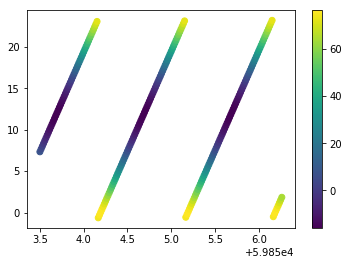

In [13]:
plt.scatter(mjd[0:200], ha[0:200], c=ddf_altaz.alt[0:200])
plt.colorbar()

In [14]:
# need the moon, to avoid getting too close
# Maybe airmass. and skybrightness. Probably only need 1-filter for skybrightness?
# Should load up scheduled downtimes

In [15]:
nside = 32
ddf_indx = raDec2Hpid(nside,ddf_coord.ra.deg, ddf_coord.dec.deg)
sm = SkyModelPre()

In [16]:
g_sb = mjd*0+np.nan

indices = np.where((sun_altaz.alt < twilight_limit*u.deg) & (ddf_airmass > airmass_limit))[0]
# In theory, one could reach into the sky brightness model and do a much faster interpolation
# There might be an airmass limit on the sky brightness.
for indx in sun_down:
    g_sb[indx] = sm.returnMags(mjd[indx], indx=[ddf_indx], filters='g', badval=np.nan)['g']

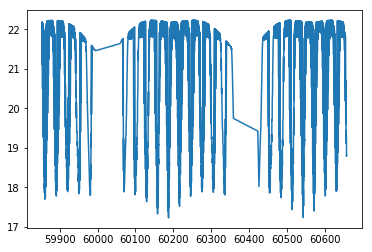

In [17]:
good = ~np.isnan(g_sb)
plt.plot(mjd[good], g_sb[good])

In [18]:
ddf_airmass[good]

array([ 1.20977504,  1.20247557,  1.19877867, ..., -1.22307345,
       -1.23785418, -1.25619914])

In [19]:
dist_to_moon = ddf_coord.separation(moon_coords)

In [20]:
seeing_model = SeeingModel()
ddf_approx_fwhmEff = seeing_model(0.7, ddf_airmass)
# I think this should pluck out the g-filter. Really should be labled
ddf_approx_fwhmEff = ddf_approx_fwhmEff['fwhmEff'][1].ravel()

/Users/yoachim/git_repos/sims_seeingModel/python/lsst/sims/seeingModel/seeingModel.py:126: RuntimeWarning: invalid value encountered in power
  airmass_correction = np.power(airmass, 0.6)


In [21]:
ddf_m5 = m5_flat_sed('g', g_sb, ddf_approx_fwhmEff, 30., ddf_airmass, nexp=1.)

/Users/yoachim/lsst/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
/Users/yoachim/lsst/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  


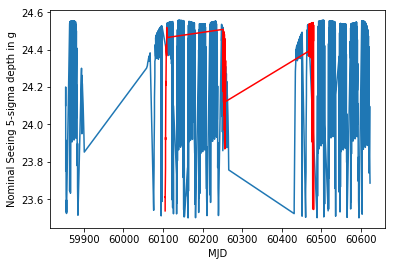

In [51]:
# demand sun down past twilight, ddf is up, and observatory is open, and not too close to the moon
good = np.where((ddf_airmass < airmass_limit) & (sun_altaz.alt < twilight_limit*u.deg) &
                (ddf_airmass > 0) & (observatory_up == True) & (dist_to_moon > dist_to_moon_limit*u.deg) &
               (ddf_zenth_dist > zenith_limit*u.deg) &
               (ddf_m5 > g_m5_limit))
plt.plot(mjd[good], ddf_m5[good])
plt.xlabel('MJD')
plt.ylabel('Nominal Seeing 5-sigma depth in g')

# Let's see if there's any downtime that is causing gaps
dt = np.where((ddf_airmass < airmass_limit) & (sun_altaz.alt < twilight_limit*u.deg) &
                (ddf_airmass > 0) & (observatory_up == False) & (dist_to_moon > dist_to_moon_limit*u.deg)&
                (ddf_zenth_dist > zenith_limit*u.deg)&
               (ddf_m5 > g_m5_limit))
plt.plot(mjd[dt], ddf_m5[dt], color='red')

In [23]:
np.where(np.isnan(ddf_m5[good]) == True)

(array([ 280,  281,  282, ..., 7431, 7447, 7463]),)

In [24]:
# A mystery nan from the sky brightness. Could be planet mask? Zenith mask?
g_sb[good[0][25]]

19.925886453865438

In [61]:

potential_nights = np.unique(night[good])
night_gap = potential_nights[1:] - potential_nights[0:-1]
big_gap = np.where(night_gap > season_gap)[0]+1
season = potential_nights*0
season[big_gap] = 1
season = np.cumsum(season)

In [62]:
# Now what do I want to do?  Make a list of potential nights. 
# Find gaps larger than N, place observations on either side, maybe two on leading side. 
# Then distribute the rest of the observations "evenly"
# now with list of nights, schedule each night at best time.
# set expiration time for each sequence.
u_seasons = np.unique(season)
season_lengths = []
for se in u_seasons:
    in_se = np.where(season == se)
    season_lengths.append(np.max(potential_nights[in_se]) - np.min(potential_nights[in_se]))
season_lengths = np.array(season_lengths)

In [63]:
season_lengths

array([ 47, 208,  36, 134])

In [68]:
good_seasons = u_seasons[np.where(season_lengths > season_length_limit)[0]]
gn = np.isin(season, good_seasons)
potential_nights = potential_nights[gn]
season = season[gn]


In [88]:
def place_obs(nights, space=2):
    """Take some input nights and flag nights as observe or not
    """
    # say 1 for an observation that can float 1.7 days, 2 for one that's good for 12 hours?
    result = np.zeros(nights.size, dtype=int) 
    # Place observations before and after each large gap
    gaps = nights*0
    gaps[1:] = nights[1:] - nights[0:-1]
    gaps[0] = space
    after_gap = np.where(gaps >= space)[0]
    result[after_gap] = 1
    pre_gap = after_gap[1:]-1
    result[pre_gap] = 2
    

    for i, night in enumerate(nights):
        if result[i] > 0:
            last_obs_indx = i
        elif (night-nights[last_obs_indx]) >= space:
            result[i] = 1
            last_obs_indx = i
    return result

In [91]:
obs_attempts = []
for sea in np.unique(season):
    night_indx = np.where(season == sea)
    obs_attempts.append(place_obs(potential_nights[night_indx]))
obs_attempts = np.concatenate(obs_attempts)

In [111]:
# now need to place the observations within the night
mjd_observe = []
for indx in np.where(obs_attempts > 0)[0]:
    in_night_indx = np.where(night == potential_nights[indx])[0]
    best_depth_indx = np.where(ddf_m5[in_night_indx] == np.nanmin(ddf_m5[in_night_indx]))[0]
    mjd_start = mjd[in_night_indx[best_depth_indx]].max()
    mjd_end = mjd_start + expire_dict[obs_attempts[indx]]
    mjd_observe.append((mjd_start, mjd_end))

In [112]:
mjd_observe

[(60058.40277780163, 60058.90277780163),
 (60060.402777801864, 60061.902777801864),
 (60062.4027778021, 60063.9027778021),
 (60064.40277780233, 60065.90277780233),
 (60066.38888891367, 60067.88888891367),
 (60067.3750000249, 60067.8750000249),
 (60076.361111137056, 60077.861111137056),
 (60078.3472222484, 60079.8472222484),
 (60080.34722224863, 60081.84722224863),
 (60082.34722224886, 60083.84722224886),
 (60084.333333360206, 60085.833333360206),
 (60086.33333336044, 60087.83333336044),
 (60088.31944447178, 60089.81944447178),
 (60090.319444472014, 60091.819444472014),
 (60092.31944447225, 60093.81944447225),
 (60094.31944447248, 60095.81944447248),
 (60096.30555558382, 60097.80555558382),
 (60097.30555558394, 60097.80555558394),
 (60110.26388891878, 60111.76388891878),
 (60112.26388891901, 60113.76388891901),
 (60114.250000030355, 60115.750000030355),
 (60116.25000003059, 60117.75000003059),
 (60118.41666669751, 60119.91666669751),
 (60120.41666669774, 60121.91666669774),
 (60122.4166